In [1]:
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import numpy as np
from itertools import combinations
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import ta
import requests
import functions

In [2]:
# Set Binance exchange
exchange = ccxt.binance({'enableRateLimit': True})

In [3]:
def close_df(symbols,since,exchange): #1656720000000
    df = pd.DataFrame()
    # First check dates:
    series_dict = {}
    for ticker in symbols:
        symbol = f'{ticker}/USDT:USDT'
        timeframe = '1d'
        limit = 500

        all_candles_perpet = []

        since_temp = since

        while True:
            candles = exchange.fetch_ohlcv(symbol, timeframe, since_temp, limit)
            if not candles:
                break
            all_candles_perpet += candles
            since_temp = candles[-1][0] + 1  # move to the next candle after last timestamp
            time.sleep(exchange.rateLimit / 500)  # avoid rate limits (to be sure we divide by 500 and not 1000) -> rate limit is is ms
        time_and_close = np.array(all_candles_perpet)[:,[0,4]]
        df = pd.DataFrame(time_and_close, columns = ['timestamp',ticker])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        series_dict[ticker] = df
    return pd.concat(series_dict.values(), axis=1)

# Create master universe

In [ ]:
# My tickers universe

tickers = ['BTC', 'ETH', 'XRP', 'BNB', 'SOL', 'TRX', 'ADA', 'HYPE', 'SUI', 'BCH', 'LINK', 'XLM', 'AVAX', 'TON', 'LTC', 'HBAR', 'XMR', 'DOT', 'UNI', 'AAVE', 'TAO', 'APT', 'ICP', 'NEAR', 'ETC', 'ONDO', 'KAS', 'VET', 'ATOM', 'POL', 'FET', 'ENA', 'RENDER', 'FIL', 'ARB', 'WLD', 'ALGO']

In [ ]:
# Function to check if ticker is available on the exchange

def is_ticker_available(symbol):
    try:
        # Try to fetch the ticker
        exchange.fetch_ticker(symbol)
        return True
    except ccxt.BaseError:
        return False

In [ ]:
# Mask to get tickers that are available on the exchange

mask = [is_ticker_available(ticker+'/USDT:USDT') for ticker in tickers]

In [ ]:
# Get only available tickers

available_tickers = [ticker for ticker, m in zip(tickers, mask) if m]

In [ ]:
# Start date for data for insample period

start_date = datetime.datetime(2021, 1, 1)
start_timestamp = int(start_date.timestamp() * 1000)

In [ ]:
# Load prices and drop coins that didn't launch

df = close_df(set(available_tickers),start_timestamp,exchange).dropna(axis=1)

In [ ]:
# End date for data for insample period

end_of_insample = pd.Timestamp('2022-12-31')
in_sample_df = df.loc[:end_of_insample]
in_sample_df.head()

,NEAR,BTC,VET,XMR,XLM,BNB,BCH,AVAX,FIL,ATOM,...,UNI,ETH,ALGO,TRX,ETC,DOT,LTC,LINK,XRP,ADA
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01,1.3607,29337.16,0.019074,135.79,0.13225,37.795,342.00,3.6541,22.233,5.873,...,4.7407,729.77,0.3987,0.02684,5.697,8.287,126.31,11.869,0.2377,0.17517
2021-01-02,1.4135,32199.91,0.020042,143.32,0.12774,38.271,354.88,3.5050,21.782,5.430,...,4.8617,775.02,0.4080,0.02721,5.782,9.213,137.08,12.226,0.2210,0.17759
2021-01-03,1.4802,33054.53,0.026307,138.73,0.13689,41.300,425.18,3.4907,21.480,5.843,...,5.5249,980.24,0.4278,0.02960,6.593,10.187,161.97,13.719,0.2265,0.20670
2021-01-04,1.3891,32031.07,0.024636,133.93,0.16440,41.142,405.66,3.6036,21.415,6.057,...,5.4320,1043.11,0.4461,0.03097,7.044,9.524,155.58,13.611,0.2361,0.22524
2021-01-05,1.5008,33999.52,0.027966,136.20,0.19320,41.799,418.74,4.2626,21.629,6.209,...,6.2595,1101.29,0.4796,0.02846,7.283,9.727,158.60,14.531,0.2258,0.25850


# First Filter Step: Keep pairs with R^2 >= 0.9

In [ ]:
from statsmodels.stats.stattools import durbin_watson
import itertools 

def ols_reg(in_sample_df: pd.DataFrame):
    # Create an empty DataFrame to store results with columns for pair and R-squared value
    df = pd.DataFrame(columns=["pair", "r_squared"])

    # Generate all possible pairs of columns (excluding self-pairs)
    pairs = list(itertools.product(in_sample_df.columns.tolist(), repeat=2))
    pairs = [t for t in itertools.product(in_sample_df.columns.tolist(), repeat=2) if len(set(t)) > 1]

    # Iterate through each unique pair
    for pair in pairs:
        # Take the log of both time series in the pair
        Y = np.log(in_sample_df[pair[0]])
        X = np.log(in_sample_df[pair[1]])

        # Perform Ordinary Least Squares regression
        model = sm.OLS(Y, sm.add_constant(X))  # Add constant term to the predictor
        results = model.fit()  # Fit the model

        # Extract R-squared value
        r_squared = results.rsquared

        # If R-squared is greater than 0.9, store the pair and R-squared in the results DataFrame
        if r_squared > 0.9:
            new_row = pd.DataFrame({'pair': [(pair[0], pair[1])], 'r_squared': [r_squared]})
            df = pd.concat([df, new_row], ignore_index=True)

    # Extract just the list of selected pairs
    pairs = df['pair'].tolist()

    # Return the DataFrame of high R-squared pairs and the list of those pairs
    return df, pairs

In [12]:
ols_result, pairs = ols_reg(in_sample_df)

/var/folders/68/g1jncml17495jn3f_j8t3g1h0000gn/T/ipykernel_39535/1680752958.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [13]:
ols_result

,pair,r_squared
0,"(BTC, DOT)",0.944876
1,"(XLM, BCH)",0.940102
2,"(XLM, FIL)",0.910490
3,"(XLM, AAVE)",0.926689
4,"(XLM, LTC)",0.908740
5,"(XLM, LINK)",0.952588
6,"(BCH, XLM)",0.940102
7,"(BCH, FIL)",0.934205
8,"(BCH, AAVE)",0.901445
9,"(BCH, LTC)",0.939154


# Second Filter Step: Spread formation on rolling basis & Stationarity Test

In [ ]:
def spread_formation(in_sample_df: pd.DataFrame,pairs=pairs,window=90):

    data_dict = {}  # Dictionary to store calculated spread, centered spread, and beta for each pair
    for pair in pairs:  # Loop over each pair of symbols

        symbol_i = pair[0]  # First symbol in the pair
        symbol_j = pair[1]  # Second symbol in the pair

        px_i = in_sample_df[symbol_i]  # Price series of symbol_i
        px_j = in_sample_df[symbol_j]  # Price series of symbol_j

        log_px_i = np.log(px_i)  # Log-price of symbol_i
        log_px_j = np.log(px_j)  # Log-price of symbol_j

        # Rolling covariance and variance to compute rolling beta
        rolling_cov = log_px_i.rolling(window=window).cov(log_px_j)
        rolling_var = log_px_i.rolling(window=window).var()

        beta = rolling_cov / rolling_var  # Rolling beta (slope of linear relationship)
        alpha = log_px_j.rolling(window=window).mean() - beta * log_px_i.rolling(window=window).mean()  # Rolling alpha (intercept)

        # Calculate spread: difference between log_px_i and the linear combination of alpha and beta * log_px_j
        spread = log_px_i - (alpha + beta * log_px_j)

        # Rolling mean of spread
        spread_mean = spread.rolling(window=window).mean()
        centered_spread = (spread - spread_mean)  # Centered spread

        # Store the calculated series in the dictionary with tuple keys
        data_dict[(tuple(pair), 'spread')] = spread
        data_dict[(tuple(pair), 'centered_spread')] = centered_spread
        data_dict[(tuple(pair), 'beta')] = beta

    data = pd.DataFrame(data_dict)  # Create a DataFrame from the dictionary

    return data  # Return the resulting DataFrame

In [26]:
data = spread_formation(in_sample_df)

In [29]:
data.dropna(inplace=True)

In [30]:
data

(BTC, DOT)                           (XLM, BCH)                  \
               spread centered_spread      beta     spread centered_spread   
timestamp                                                                    
2021-06-28  29.187024        2.580803  1.363400 -21.828948        1.427571   
2021-06-29  29.547510        3.041570  1.382693 -21.761355        1.549252   
2021-06-30  29.845278        3.430455  1.400247 -21.741149        1.623202   
2021-07-01  30.196780        3.862475  1.415381 -21.736212        1.680261   
2021-07-02  30.412872        4.152968  1.426776 -21.727460        1.735446   
...               ...             ...       ...        ...             ...   
2022-12-27  27.065132       -0.721805  1.149855 -14.303690        2.411117   
2022-12-28  27.475066       -0.309921  1.169935 -14.342130        2.283254   
2022-12-29  27.821526        0.037690  1.188799 -14.334592        2.202058   
2022-12-30  28.143162        0.359941  1.206641 -14.362856        2.090281   
2022-12-31  28.478726        0.694781  1.224899 -14.428375        1.944318   

                     (XLM, FIL)                           (XLM, AAVE)  ...  \
                beta     spread centered_spread      beta      spread  ...   
timestamp                                                              ...   
2021-06-28  0.923108 -17.063210        3.223829  1.131420  -18.801602  ...   
2021-06-29  0.917684 -17.167200        3.134734  1.137963  -18.800116  ...   
2021-06-30  0.914185 -17.101484        3.205655  1.143069  -18.845864  ...   
2021-07-01  0.912712 -17.081380        3.218289  1.144874  -18.850312  ...   
2021-07-02  0.907968 -17.125168        3.150767  1.149425  -18.895461  ...   
...              ...        ...             ...       ...         ...  ...   
2022-12-27  0.248717 -11.921758        0.049578  1.085772  -18.643818  ...   
2022-12-28  0.249989 -11.970157       -0.060761  1.093666  -18.610643  ...   
2022-12-29  0.249987 -12.008034       -0.158579  1.102345  -18.618048  ...   
2022-12-30  0.254282 -12.096804       -0.300099  1.118695  -18.677628  ...   
2022-12-31  0.259360 -12.198166       -0.449983  1.131070  -18.776526  ...   

           (LINK, BCH) (LINK, FIL)                           (LINK, AAVE)  \
                  beta      spread centered_spread      beta       spread   
timestamp                                                                   
2021-06-28    0.984547   -3.134219       -1.695709  1.152890    -7.730260   
2021-06-29    0.978154   -3.236200       -1.787903  1.154289    -7.721259   
2021-06-30    0.973000   -3.138608       -1.679717  1.156820    -7.761704   
2021-07-01    0.970491   -3.135588       -1.662465  1.153086    -7.758851   
2021-07-02    0.965053   -3.123087       -1.636596  1.154786    -7.761506   
...                ...         ...             ...       ...          ...   
2022-12-27    0.492110    3.209880        1.924512  1.623932    -6.888728   
2022-12-28    0.491993    3.261581        1.950634  1.640699    -6.844527   
2022-12-29    0.487372    3.282906        1.945807  1.649103    -6.874852   
2022-12-30    0.486642    3.264579        1.901623  1.649935    -6.848881   
2022-12-31    0.488096    3.283819        1.894846  1.655190    -6.819028   

                                     (LINK, LTC)                            
           centered_spread      beta      spread centered_spread      beta  
timestamp                                                                   
2021-06-28        0.073571  0.797816   -5.876029       -0.165630  0.999666  
2021-06-29        0.088533  0.802155   -5.894690       -0.189827  0.996183  
2021-06-30        0.054875  0.802847   -5.903007       -0.203440  0.993093  
2021-07-01        0.063452  0.804366   -5.934039       -0.238547  0.989264  
2021-07-02        0.067369  0.806075   -5.936296       -0.245104  0.985515  
...                    ...       ...         ...             ...       ...  
2022-12-27        0.131372  1.269725   -6.432161     

In [72]:
def cointegration (data,pairs=pairs, threshold=0.05):
    temp = {}
    new_pairs = []
    df = pd.DataFrame(columns=["coin_1","coin_2","p_value", "test_stat"])
    tickers = []
    #pairs = data.columns.tolist()

    for pair in pairs:
        spread = data[(pair,'spread')].values
        adf_test = adfuller(spread)
        test_statistic = adf_test[0]
        p_val = adf_test[1]
        #one_percent = crit_values[0]

        if p_val < 0.05: #and coint_stat<one_percent:
            new_pairs.append(pair)
            new_row = pd.DataFrame({'coin_1': [pair[0]],'coin_2': [pair[1]], 'p_value': [p_val], 'test_stat': [test_statistic]})
            df = pd.concat([df, new_row], ignore_index=True)

    return new_pairs, df

In [ ]:
def cointegration(data, pairs=pairs, threshold=0.05):

    new_pairs = []  # To store pairs that are cointegrated
    df = pd.DataFrame(columns=["coin_1", "coin_2", "p_value", "test_stat"])  # DataFrame to store test results

    for pair in pairs:  # Loop over each pair
        spread = data[(pair, 'spread')].values  # Retrieve the spread series for the pair
        adf_test = adfuller(spread)  # Perform Augmented Dickey-Fuller test on the spread
        test_statistic = adf_test[0]  # Extract test statistic
        p_val = adf_test[1]  # Extract p-value from ADF result

        # If the p-value is below the threshold, consider the pair cointegrated
        if p_val < threshold:
            new_pairs.append(pair)  # Store the cointegrated pair
            # Create a new row with test results and append to the DataFrame
            new_row = pd.DataFrame({'coin_1': [pair[0]], 'coin_2': [pair[1]], 'p_value': [p_val], 'test_stat': [test_statistic]})
            df = pd.concat([df, new_row], ignore_index=True)  # Append new row to result DataFrame

    return new_pairs, df  # Return the list of cointegrated pairs and the results DataFrame


In [ ]:
new_pairs,coint_df = cointegration(data)

/var/folders/68/g1jncml17495jn3f_j8t3g1h0000gn/T/ipykernel_39535/3368074136.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [ ]:
coint_df.sort_values(by='test_stat')

,coin_1,coin_2,p_value,test_stat
0,BTC,DOT,0.004760,-3.657036
4,AAVE,UNI,0.009716,-3.438435
5,AAVE,LINK,0.012358,-3.361106
3,AAVE,BCH,0.016624,-3.262839
2,AAVE,XLM,0.029712,-3.059341
1,BCH,LINK,0.035326,-2.995406


In [75]:
temp = []
unique_transitions = []
for pair in new_pairs:
    if pair[0] not in temp and pair[1] not in temp:
        temp.append(pair[0])
        temp.append(pair[1])
        unique_transitions.append(pair[0])

In [76]:
def filter(df):
    keep_indices = []
    for ticker in unique_transitions:
        keep_indices.append(df[(df['coin_1'] == ticker) | (df['coin_2'] == ticker)].sort_values(by='test_stat').index[0])

    sorted_df = df.sort_values(by=['coin_1','test_stat']).drop_duplicates(subset=['coin_1'])
    sorted_df = sorted_df.sort_values(by=['coin_2','test_stat']).drop_duplicates(subset=['coin_2'])
    sorted_df = sorted_df[sorted_df.index.isin(set(keep_indices))]
    sorted_df.reset_index(drop=True,inplace=True)
    
    return sorted_df

In [ ]:
new_df = filter(coint_df)

In [84]:
final_pairs = new_df[['coin_1','coin_2']].values.tolist()

# Visualisation of pair spreads

/var/folders/68/g1jncml17495jn3f_j8t3g1h0000gn/T/ipykernel_39535/95652194.py:3: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(data[((pair[0],pair[1]), 'centered_spread')], label=pair)


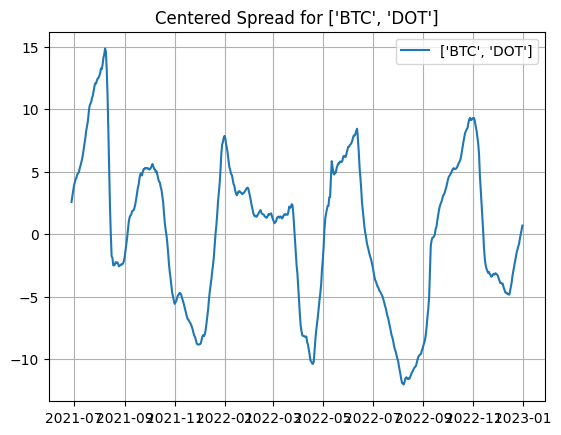

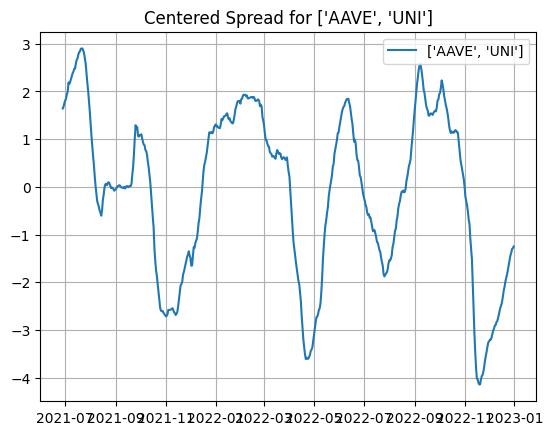

In [85]:
for pair in final_pairs:
    plt.figure()  # This creates a new window/figure
    plt.plot(data[((pair[0],pair[1]), 'centered_spread')], label=pair)
    plt.title(f'Centered Spread for {pair}')
    plt.legend()
    plt.grid()
    plt.show()

# Backtest

In [161]:
start_of_out_sample = end_of_insample + pd.DateOffset(days=1)
end_of_out_sample = start_of_out_sample + pd.DateOffset(years=1)

In [162]:
def generate_weights(signals_df, threshold=0.5):
    # Initialize a DataFrame with the same index and columns as crypto_px, filled with NaN

    nb_trades = 0
    pairs = signals_df.columns.get_level_values(0).unique().tolist()
    signals_df = signals_df.loc[start_of_out_sample:end_of_out_sample]


    pos = pd.DataFrame(index=signals_df.index, columns=in_sample_df.columns,dtype=float)

    tickers = [ticker for pair in pairs for ticker in pair]
   
    #z_scores = signals_df[(tuple(pair), 'z_score')]

    for pair in pairs:
        asset_i = pair[0]
        asset_j = pair[1]
        betas = signals_df[(tuple(pair), 'beta')]
        # If negative beta, replace by recent positive
        #betas[betas<=0] = np.nan
        #betas.ffill(inplace=True)
        z_scores = signals_df[(tuple(pair), 'centered_spread')]
        fast_sma = z_scores.rolling(8).mean()
        slow_sma = z_scores.rolling(16).mean()
        #std_i = signals_df[(tuple(pair), 'std_i')]
        #std_j = signals_df[(tuple(pair), 'std_j')]
        diff = fast_sma.diff()

        short_pos = 0
        long_pos = 0

        long_trigger = False
        short_trigger = False

        
        for ind in pos.index:


            if long_pos == 1:
                pos.loc[ind, asset_j] = -betas.loc[ind]#*(1/std_j.loc[ind])
                pos.loc[ind,asset_i] = 1#*(1/std_i.loc[ind])
                nb_trades = nb_trades+1
            elif short_pos == 1:
                pos.loc[ind, asset_j] = betas.loc[ind]#*(1/std_j.loc[ind])
                pos.loc[ind,asset_i] = -1#*(1/std_i.loc[ind])
                nb_trades = nb_trades+1

            if (z_scores.loc[ind] > 0) and (z_scores.shift().loc[ind]<= 0):
                short_trigger = True
                long_trigger = False

            elif (z_scores.loc[ind]) < 0 and (z_scores.shift().loc[ind]>= 0):
                long_trigger = True
                short_trigger = False

            if (short_trigger == True) and (fast_sma.loc[ind]<slow_sma.loc[ind]) and (short_pos == 0) and (np.abs(z_scores.loc[ind]) > threshold):
            #if (short_trigger == True) and (diff.loc[ind]<0) and (short_pos == 0) and (np.abs(z_scores.loc[ind]) > threshold):
                pos.loc[ind,asset_i] = -1 #*(1/std_i.loc[ind])
                pos.loc[ind, asset_j] = betas.loc[ind] #*(1/std_j.loc[ind])
                short_pos = 1
                short_trigger = False

            elif (long_trigger == True) and (fast_sma.loc[ind]>slow_sma.loc[ind]) and (long_pos == 0) and (np.abs(z_scores.loc[ind]) > threshold):
            #elif (long_trigger == True) and (diff.loc[ind]>0) and (long_pos == 0) and (np.abs(z_scores.loc[ind]) > threshold):
                pos.loc[ind, asset_i] = 1 #*(1/std_i.loc[ind])
                pos.loc[ind, asset_j] = -betas.loc[ind]#*(1/std_j.loc[ind])
                long_pos = 1
                long_trigger = False

            if (short_pos == 1) and (np.abs(z_scores.loc[ind]) <= threshold):
                pos.loc[ind, asset_i] = 0 
                pos.loc[ind, asset_j] = 0
                short_pos = 0
                nb_trades = nb_trades+1
            


            elif (long_pos == 1) and (np.abs(z_scores.loc[ind]) <= threshold):
                pos.loc[ind, asset_j] = 0  
                pos.loc[ind, asset_i] = 0
                long_pos = 0
                nb_trades = nb_trades+1
                
        #pos[[asset_i,asset_j]] = pos[[asset_i,asset_j]].divide(pos[[asset_i,asset_j]].abs().sum(axis=1), axis=0)/2
            

    # Forward-fill missing values
    pos = pos.ffill()
    # Normalization to get fully invested portfolio and divide by number of pairs to not be concerated if only one pair is active
    pos_final = (pos.divide(pos.abs().sum(axis=1), axis=0).fillna(0))
    print(nb_trades)
    return pos_final

In [ ]:
spreads = spread_formation(df,pairs=final_pairs,window=90)
spreads.dropna(inplace=True)

In [165]:
wts = generate_weights(spreads, threshold=0.001)

635


In [166]:
coins_ret = df.pct_change().dropna()

In [167]:
def compute_turnover(port):
    to = (port.fillna(0)-port.shift().fillna(0)).abs().sum(1)   
    return to

In [168]:
# Calculate out-of-sample daily returns (we shift to avoid look ahead biais)
out_sample_ret = coins_ret.loc[start_of_out_sample:end_of_out_sample]
strat_gross_ret = (wts.shift() * out_sample_ret).sum(1)
    
# Calculate net returns
to = compute_turnover(wts)
tcost_bps = 20  # (commissions + slippage)
strat_net_ret = strat_gross_ret.subtract(to * tcost_bps * 1e-4, fill_value=0)

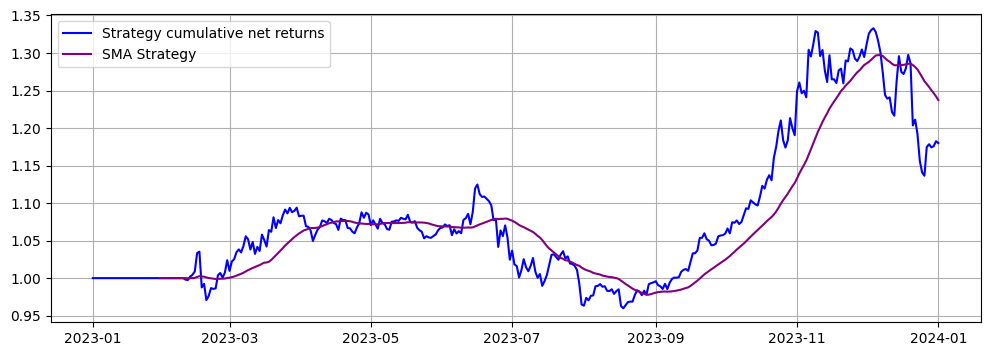

In [169]:
plt.figure(figsize=(12, 4))
plt.plot((1+strat_net_ret).cumprod(),label='Strategy cumulative net returns',color='blue')
plt.plot((1+strat_net_ret).cumprod().rolling(30).mean(),color = 'purple',label='SMA Strategy')
plt.legend()
plt.grid()

/var/folders/68/g1jncml17495jn3f_j8t3g1h0000gn/T/ipykernel_39535/1510478640.py:3: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(spreads[((pair[0],pair[1]), 'centered_spread')].loc[:end_of_out_sample], label=pair)


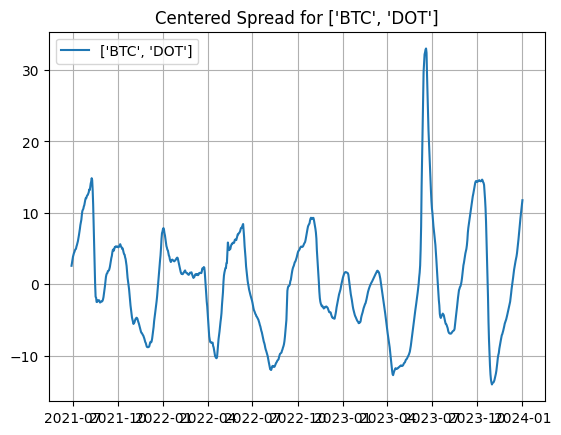

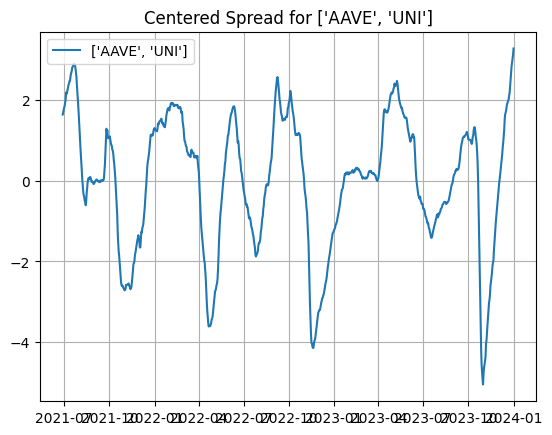

In [172]:
for pair in final_pairs:
    plt.figure()  # This creates a new window/figure
    plt.plot(spreads[((pair[0],pair[1]), 'centered_spread')].loc[:end_of_out_sample], label=pair)
    plt.title(f'Centered Spread for {pair}')
    plt.legend()
    plt.grid()
    plt.show()